# Graph Powered Machine Learning - Exercise 2
_Solution authors_:

Mateo Sokač
- Student ID: au589901 (Aarhus University)
- Email Address: mateo.sokac@clin.au.dk

Lukas Hedegaard Morsing
- Student ID: au478108 (Aarhus University)]
- Email Address: lh@eng.au.dk

## 1. A Comprehensive Survey on Graph Neural Networks
Read sections 1,2,3,6 of the [A Comprehensive Survey on Graph Neural Networks](https://arxiv.org/pdf/1901.00596v1.pdf) and discuss the following questions (roughly 1-2 paragraphs each):

### 1. How are network embeddings and GCNs related?

Network embeddings the task of transforming network data into a metric space (where the network relationships and content are preserved). 
This can be achieved using GCNs such as GraphSAGE or a Graph Autoencoder.

### 2. What are the potential outputs of GCNs? Please describe one use-case for each potential output.

- Node classifications. In a semi-supervised case, where a few nodes are labelled, a technique such as label smoothing can be used.
    - Use case: Voter prediction


- Graph classification. In this case pooling is used along the way to reduce the number of nodes in the transformed graph. 
    - Use case: Human Activity Recognition


- Condensed graph / embedding. These can be created using a Graph-Autoencoder
    - Use case: Efficient storage of graphs
    


### 3. What value is added by Graph Attention Networks over GCNs? What are potential disadvantage?

Advantages:

\+ Inductive capabilities. You can learn stuff on one graph and transfer it to unseen graphs.

\+ Explainability. Attention weights directly express how important a neighbour is to another nodes state/feature.

Disadvantages:

- The mode has more parameters, which has a effect on: 
    - training time, 
    - memory consumption, 
    - inference time.


### 4. Why are GCNs relevant for Computer Vision?

There a few use-cases, where GCNs perform well.
- Skeleton-based Activity Recognition: First, you extract landmarks for the human body. These can then be connected in a graph. Finally, you perform a graph prediction.
- Image Segmentation: Create superpixels, then classify superpixels as nodes in a graph. This will produce a segmentation map.

## 2. Graph Learning Tasks
Pick one of the following Graph Learning Tasks from the [DGL Guide](https://docs.dgl.ai/guide/training.html) and create a python tutorial (preferably as jupyter notebook) for that example. Feel free to choose another dataset (http://kaggle.com is a good starting point).

## Link prediction
We'll be going through the [StellarGraph example on link prediction using GCNs](https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html) and implementing it using DGL.

In [1]:
import dgl
import torch
from torch import nn
import networkx as nx
from dgl.nn.pytorch.conv import SAGEConv, GATConv
from dgl.data import CoraGraphDataset
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
dataset = CoraGraphDataset()
g = dataset[0]

# get node feature
feat = g.ndata['feat']

# get data split
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

train_g = g.edge_subgraph(train_mask,preserve_nodes=False)
val_g = g.edge_subgraph(val_mask,preserve_nodes=False)
test_g = g.edge_subgraph(test_mask,preserve_nodes=False)

# get labels
label = g.ndata['label']

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


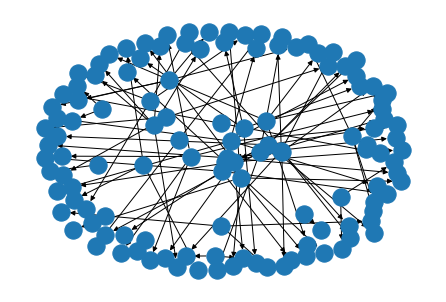

In [3]:
# Lets draw some data
num_printed = 100
nx.draw(train_g.edge_subgraph(range(num_printed),preserve_nodes=False).to_networkx())

In [4]:
# Create model
# Adopted from https://docs.dgl.ai/guide/training-link.html?fbclid=IwAR3wWidiyuzcR7LqOdlojkNWJ4tATRR3V-NrzjGZdErjqji4VwxicnG_PBc#guide-training-link-prediction

class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(dgl.function.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']
        
        
def construct_negative_graph(graph, k):
    src, dst = graph.edges()

    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.number_of_nodes(), (len(src) * k,))
    return dgl.graph((neg_src, neg_dst), num_nodes=graph.number_of_nodes())


class Model(nn.Module):
    def __init__(self, in_features, out_features, dropout = 0.4):
        super().__init__()
        self.sage = SAGEConv(in_features, out_features, aggregator_type="mean", feat_drop=dropout)
        self.pred = DotProductPredictor()
    def forward(self, g, neg_g, x):
        h = self.sage(g, x)
        return self.pred(g, h), self.pred(neg_g, h)
    

def compute_loss(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - neg_score.view(n_edges, -1) + pos_score.unsqueeze(1)).clamp(min=0).mean()



In [5]:
# Initiate model
node_features = train_g.ndata['feat']
n_features = node_features.shape[1]
k = 5 
model = Model(
    in_features=n_features, 
    out_features=100,
)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [6]:
# Training loop

epochs = 300
print_step = 20

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Train step
    model.train()
    node_features = train_g.ndata['feat']
    negative_graph = construct_negative_graph(train_g, k)
    pos_score, neg_score = model(train_g, negative_graph, node_features)
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    train_losses.append(loss)
    
    # Val step
    model.eval()
    node_features = val_g.ndata['feat']
    negative_graph = construct_negative_graph(val_g, k)
    pos_score, neg_score = model(val_g, negative_graph, node_features)
    val_loss = compute_loss(pos_score, neg_score)
    val_losses.append(val_loss)
    
    if epoch % print_step == 0:
        print(f"Epoch {epoch}: Train loss = {loss.item()}, Val loss: {val_loss.item()}")

Epoch 0: Train loss = 1.0023572444915771, Val loss: 1.0017521381378174
Epoch 20: Train loss = 0.9679009914398193, Val loss: 0.9979072213172913
Epoch 40: Train loss = 0.8922980427742004, Val loss: 0.9872298836708069
Epoch 60: Train loss = 0.7466632127761841, Val loss: 0.9635586738586426
Epoch 80: Train loss = 0.5772829055786133, Val loss: 0.9387992024421692
Epoch 100: Train loss = 0.4850219190120697, Val loss: 0.9357361197471619
Epoch 120: Train loss = 0.37034642696380615, Val loss: 0.9374284148216248
Epoch 140: Train loss = 0.3042476773262024, Val loss: 0.9358850121498108
Epoch 160: Train loss = 0.19995975494384766, Val loss: 0.9439581036567688
Epoch 180: Train loss = 0.18677158653736115, Val loss: 0.9420909881591797
Epoch 200: Train loss = 0.11249513924121857, Val loss: 0.9447985291481018
Epoch 220: Train loss = 0.1227903813123703, Val loss: 0.9479895234107971
Epoch 240: Train loss = 0.09848076105117798, Val loss: 0.9465941190719604
Epoch 260: Train loss = 0.07950463145971298, Val los

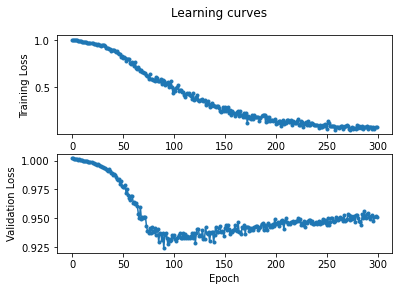

In [7]:
# Plot learning curves:
tick = range(epochs)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Learning curves')

ax1.plot(tick, train_losses, '.-')
ax1.set_ylabel('Training Loss')

ax2.plot(tick, val_losses, '.-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')

plt.show()

The model clearly overfits around 100 epochs. We'll leave it be for now, though. 😇

In [8]:
# Test
model.eval()
node_features = test_g.ndata['feat']
negative_graph = construct_negative_graph(test_g, k)
pos_score, neg_score = model(test_g, negative_graph, node_features)
test_loss = compute_loss(pos_score, neg_score)

print(test_loss)

tensor(0.9444, grad_fn=<MeanBackward0>)
